### Setup

In [1]:
import numpy as np
from sklearn.datasets import make_regression
from sklearn.pipeline import make_pipeline
from sklearn.linear_model import ElasticNetCV, LinearRegression
from sklearn.svm import LinearSVR, SVR
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import cross_validate, train_test_split, RepeatedKFold, GridSearchCV
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from sklearn.ensemble import GradientBoostingRegressor
import matplotlib.pyplot as plt

In [2]:
from warnings import filterwarnings
filterwarnings('ignore')

In [3]:
test_share=0.2 
cv_folds=10
cv_reps=20
cv_count=cv_folds*cv_reps
rs=1 # random_state for reproducibility

##### Example Dataset

In [4]:
X, y, w = make_regression(n_samples=150,
                          n_features=50, # x variables generated and returned 
                          n_informative=4, # x variables included in the actual model of y
                          effective_rank=2, # make less than n_informative for multicollinearity
                          coef=True,
                          noise=1,
                          random_state=rs,
                          bias=1.5)

In [5]:
# add interaction terms

In [6]:
if test_share:
     X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=test_share, random_state=rs)
else:
    X_train, X_test, y_train, y_test = (X, None, y, None)

### Model Selection

In [7]:
# for elastic_net, add custom transformer to change data to Fortran contiguous if not?
linear_regression=make_pipeline(StandardScaler(),LinearRegression())
elastic_net = make_pipeline(StandardScaler(), ElasticNetCV())
#linear_svr = make_pipeline(StandardScaler(),GridSearchCV(LinearSVR(random_state=rs,tol=1e-3,max_iter=5000),n_jobs=1,param_grid={'C':np.linspace(-1,4,8)}))
linear_svr = make_pipeline(StandardScaler(),LinearSVR(random_state=rs,tol=1e-4,max_iter=5000,C=1))
rbf_svr=make_pipeline(StandardScaler(),SVR(kernel='rbf',tol=1e-4,max_iter=5000, C=1))
gradient_boosting_reg=make_pipeline(StandardScaler(),GradientBoostingRegressor())

model_dict={'linear-regression':linear_regression,
            'elastic-net':elastic_net, 
            'linear-svr':linear_svr, 
            'rbf-svr':rbf_svr, 
            'gradient-boosting-reg':gradient_boosting_reg}

In [8]:
scorer_list=['neg_mean_squared_error', 'neg_mean_absolute_error', 'r2'] #cross_validate wants strings
cv=RepeatedKFold(n_splits=cv_folds, n_repeats=cv_reps, random_state=rs) # define separately to ensure same cv data used for each model
# allow/generate water quality thresholds for stratified kfold sub-sampling to ensure cross-validation folds have full range of water quality

In [9]:
cv_results={model_name:cross_validate(model, X_train, y_train, return_estimator=True, scoring=scorer_list, cv=cv)
            for model_name,model in model_dict.items()}
# replace with a loop in order to save the residuals for a graph?

### graphs and table to summarize results

In [10]:
cv_score_dict={}
cv_score_dict_means={}
for idx,(model_name,result) in enumerate(cv_results.items()):
    #cv_estimators=result['estimator']
    #cv_estimator_names=[str(type(est)).split(".")[-1][:-2] for est in cv_estimators
    model_idx_scoredict={scorer:result[f'test_{scorer}'] for scorer in scorer_list}
    cv_score_dict[model_name]=model_idx_scoredict # fstring bc how cross_validate stores list of metrics
    model_idx_mean_scores={scorer:np.mean(scores) for scorer,scores in model_idx_scoredict.items()}
    cv_score_dict_means[model_name]=model_idx_mean_scores

In [11]:
for scorer in scorer_list:
    print(f'scores for scorer: {scorer}:')
    for model_name in model_dict:
        print(f'    {model_name}:{cv_score_dict_means[model_name][scorer]}')

scores for scorer: neg_mean_squared_error:
    linear-regression:-1.5179573053207582
    elastic-net:-1.0296989676829722
    linear-svr:-1.7960251923393127
    rbf-svr:-4.238093136320112
    gradient-boosting-reg:-2.0586317650260084
scores for scorer: neg_mean_absolute_error:
    linear-regression:-1.0062429677545537
    elastic-net:-0.8353971777697842
    linear-svr:-1.0798307054938332
    rbf-svr:-1.626217444301867
    gradient-boosting-reg:-1.113144988300621
scores for scorer: r2:
    linear-regression:0.7718835791732863
    elastic-net:0.8487770138451736
    linear-svr:0.7289512104424002
    rbf-svr:0.4279910253662406
    gradient-boosting-reg:0.7112055901337122


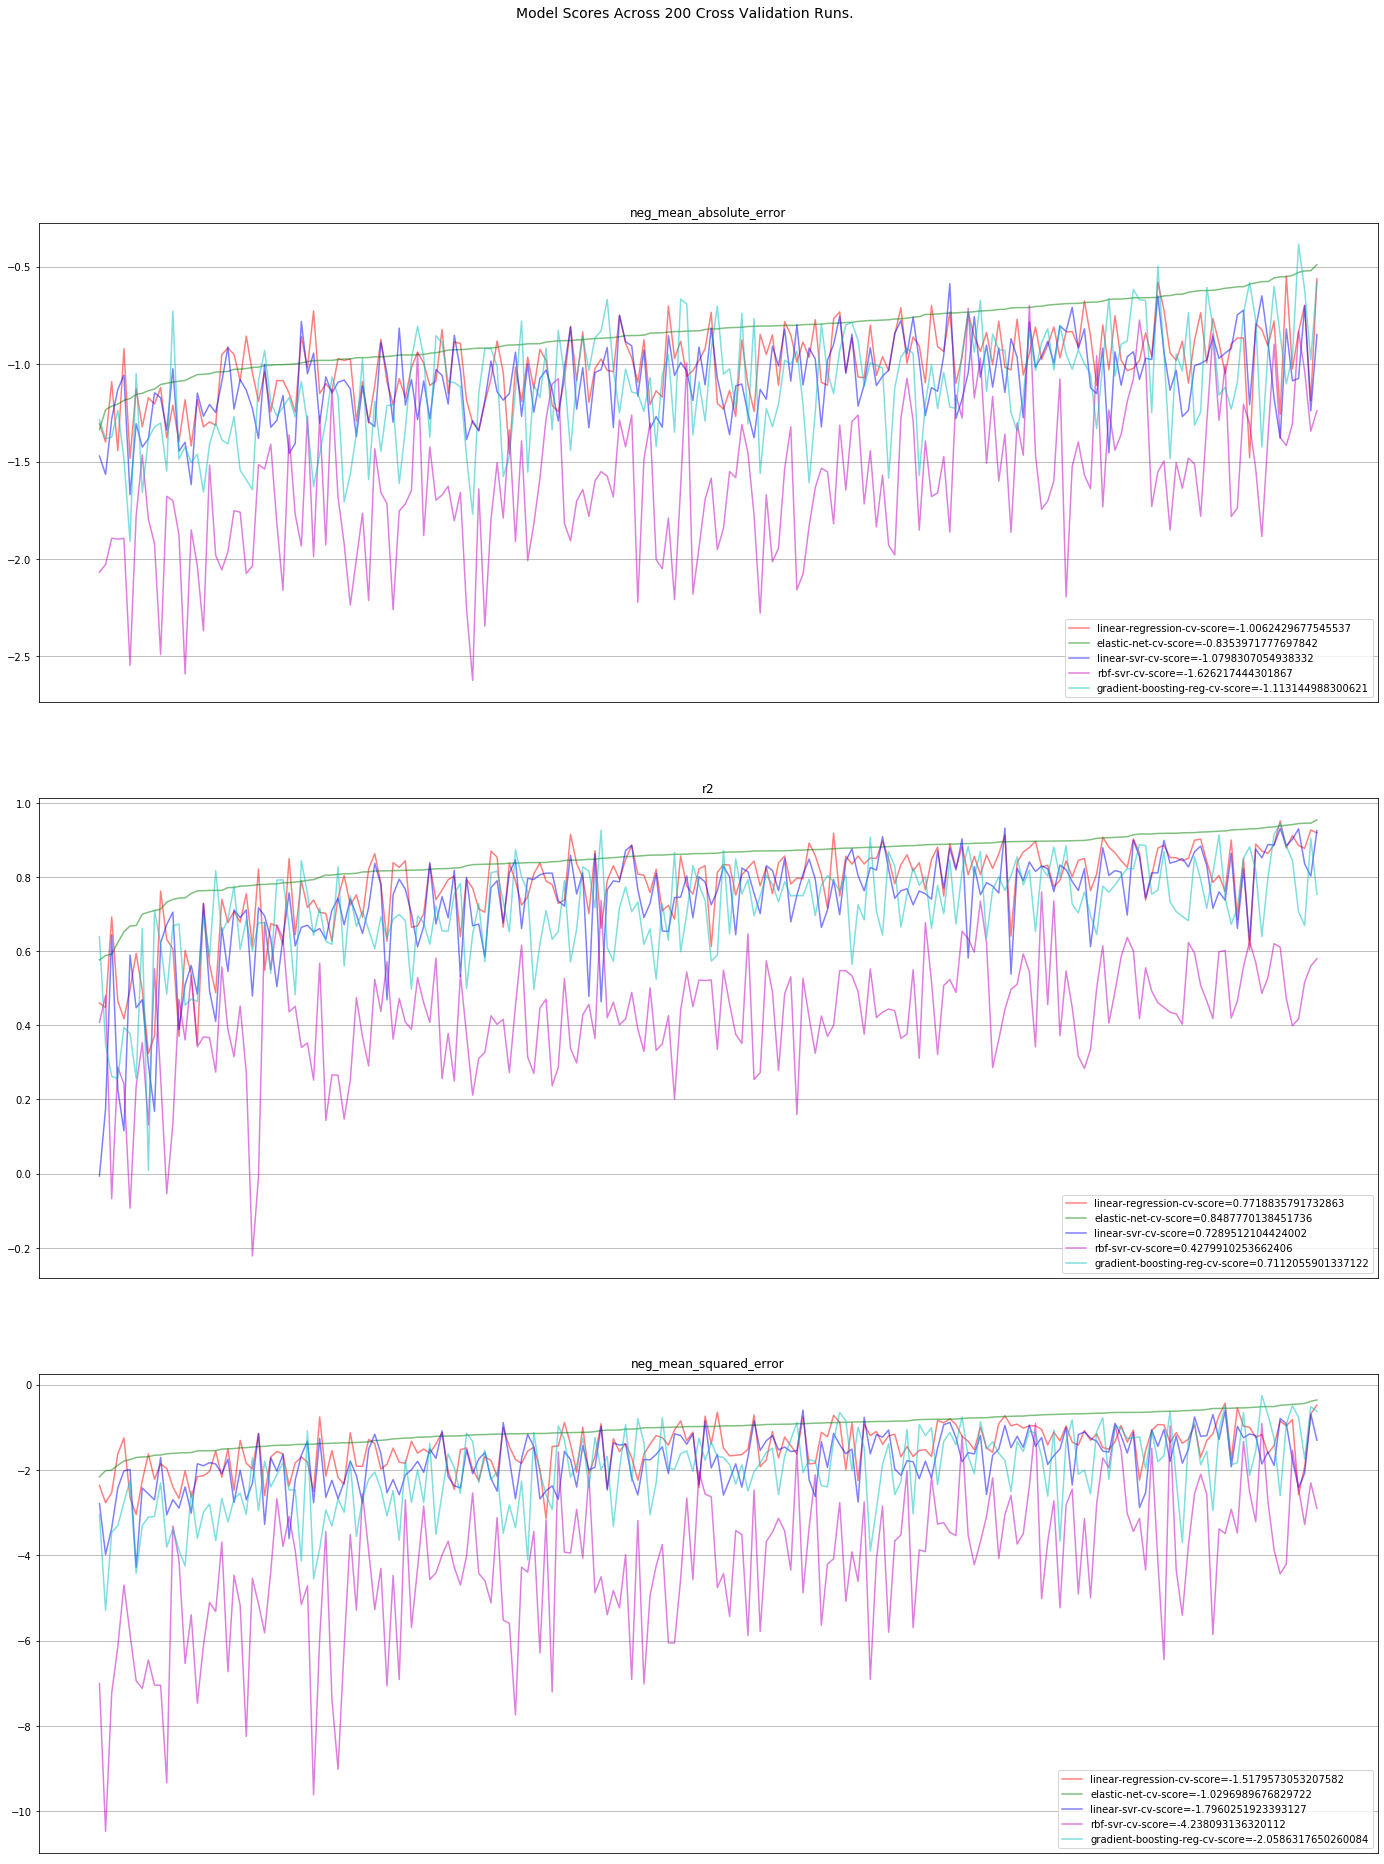

In [12]:
colors = ['r', 'g', 'b', 'm', 'c', 'y', 'k']    
fig=plt.figure(figsize=[24,30])
plt.suptitle(f"Model Scores Across {cv_count} Cross Validation Runs. ", fontsize=14)
s_count=len(scorer_list)
xidx=np.arange(cv_count) # place holder for scatterplot

for s_idx, scorer in enumerate(scorer_list):
    ax=fig.add_subplot(f'{s_count}1{s_idx}')
    #ax.set_xlabel('estimator')
    #ax.set_ylabel(scorer)
    ax.set_title(scorer)
    sortidx=np.argsort(cv_score_dict['elastic-net'][scorer])
    #sortidx=np.argsort(cv_score_dict['linear-regression'][scorer])
    #sortidx=slice(None)
    for m_idx,model_name in enumerate(cv_results.keys()):
        ax.plot(xidx,cv_score_dict[model_name][scorer][sortidx],color=colors[m_idx],alpha=0.5,label=model_name+'-cv-score='+str(np.mean(cv_score_dict[model_name][scorer])))
    ax.grid(True)
    ax.xaxis.set_ticks([])
    ax.xaxis.set_visible(False)
    ax.legend(loc=4)

    

In [13]:
# create a similar plot showing residuals from the cv models for each value of y. 
# needs to be scatterplot or histogram since there will be (folds-1)*repeats predictions of each value of y.

-----------------------------
### User chooses elastic net!


In [14]:
final_model_name='elastic-net'

In [15]:
def printTestandCVScores(model_name):
    final_model=model_dict[model_name]
    final_model.fit(X_train,y_train)
    if test_share:
        y_test_hat=final_model.predict(X_test)
        print(f'test set: negative-mse={-mean_squared_error(y_test,y_test_hat)}')
    for scorer in scorer_list:
        print(f'cv avg: {scorer}= {cv_score_dict_means[model_name][scorer]}')    

In [16]:
printTestandCVScores(final_model_name)

test set: negative-mse=-1.7474976775288467
cv avg: neg_mean_squared_error= -1.0296989676829722
cv avg: neg_mean_absolute_error= -0.8353971777697842
cv avg: r2= 0.8487770138451736


In [17]:
printTestandCVScores('linear-regression')

test set: negative-mse=-1.6855671280787012
cv avg: neg_mean_squared_error= -1.5179573053207582
cv avg: neg_mean_absolute_error= -1.0062429677545537
cv avg: r2= 0.7718835791732863


## Next Steps
- ### add options for dealing with important but underrepresented values of Y
- ### construct model averaging using average cross validation scores
- ### predict with confidence intervals 
  -    #### could use variability from cv
  -   #### some algorithms have their own method
